## Import libraries and mount the drive

In [35]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.2.0-rc3
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset

## Loading train, validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions


In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 6:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        return image0, image1, image2, image3, image4, image5
    return image0, image1, image2, image3

In [0]:
def retrieve_tumor_area(ground_truth, prediction, segmentation):
    ground_truth_np = ground_truth.numpy()
    segmentation_np = segmentation.numpy()
    prediction_np = prediction.numpy()

    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction_np[idx] = segmentation_np[idx]

    return ground_truth_np, prediction_np      # Now the images are ready to be evaluated

## Evaluate GAN

In [0]:
def evaluate_GAN(model, dataset, set_type, evaluate_tumor_area=False, print_loss=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    if print_loss:
        container_gen = tf.TensorArray(tf.float32, size=num_batches)     
        container_disc = tf.TensorArray(tf.float32, size=num_batches)
    
    for idx, (t1, t2, t1c, t2flair, segmentation, patient) in dataset.enumerate():
        
        # preparing the input to the generator
        ground_truth = t2flair
        input_tensor = tf.concat([t1, t1c, t2], 3)

        prediction = model(input_tensor, training=False)

        # crop the images
        t1_cr, t1c_cr, t2_cr, gt_cr, pred_cr, segmentation_cr = resize_with_crop(t1, t1c, t2, ground_truth, prediction, segmentation)
        if evaluate_tumor_area:
            prediction_normalized = mean_normalize(pred_cr)
            ground_truth_normalized = mean_normalize(gt_cr) 
            ground_truth_masked, prediction_masked = retrieve_tumor_area(ground_truth_normalized, prediction_normalized, segmentation_cr)
        
        # PLOT ALWAYS THE SAME IMAGES, SO THAT IT'S EASIER TO PERCEIVE DIFFERENCES IN THE PREDICTIONS BETWEEN EPOCHS.
        if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83) and evaluate_tumor_area:
            plot_images(t1_cr, t1c_cr, t2_cr, gt_cr, pred_cr, ground_truth_masked, prediction_masked)
        elif idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:
            plot_images(t1_cr, t1c_cr, t2_cr, gt_cr, pred_cr)

        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(pred_cr)
        ground_truth_normalized_cr = mean_normalize(gt_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:
            mean, std, psnr = compute_psnr_tumor(ground_truth_masked, prediction_masked)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked, prediction_masked)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked, prediction_masked)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)

        # COMPUTES VALIDATION LOSSES FOR THE GENERATOR AND THE DISCRIMINATOR
        if print_loss:
            ####################################
            zeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)
            ones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)
            
            disc_generated_output = discriminator([input_tensor, prediction], training=True)
            disc_real_output = discriminator([input_tensor, ground_truth], training=True)

            # SELECTIVE LOSS COMPUTATION & SELECTIVE DISCRIMINATION IN D
            gen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output, prediction, ground_truth, ones)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output, zeros, ones) * 0.5

            container_gen = container_gen.write(idx, gen_total_loss)
            container_disc = container_disc.write(idx, disc_loss)
            ###############################
       # idx += 1

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        
        threshold = 228 # I don't consider values with PSNR > 228, because it means we are looking basically at black images.
        container_psnr_tumor = tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor))
        container_psnr_tumor = container_psnr_tumor[container_psnr_tumor < threshold]

        mean_psnr_tumor = tf.reduce_mean(container_psnr_tumor)
        std_psnr_tumor = tf.math.reduce_std(container_psnr_tumor)
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))
    if print_loss:
        container_disc = container_disc.stack()
        container_gen = container_gen.stack()
        mean_gen = tf.reduce_mean(tf.boolean_mask((container_gen), tf.math.is_finite(container_gen)))
        std_gen = tf.math.reduce_std(tf.boolean_mask((container_gen), tf.math.is_finite(container_gen)))
        mean_disc = tf.reduce_mean(tf.boolean_mask((container_disc), tf.math.is_finite(container_disc)))
        std_disc = tf.math.reduce_std(tf.boolean_mask((container_disc), tf.math.is_finite(container_disc)))
        print()
        print("Generator loss on {} set: {} ± {}".format(set_type, (f'{mean_gen:.4f}'), (f'{std_gen:.4f}')))
        print("Discriminator loss on {} set: {} ± {}".format(set_type, (f'{mean_disc:.4f}'), (f'{std_disc:.4f}')))
        
    if tf.equal(print_loss, True) and tf.equal(evaluate_tumor_area, False):
        return mean_psnr, mean_mse, mean_ssim, mean_gen, mean_disc
    elif tf.equal(print_loss, False) and tf.equal(evaluate_tumor_area, True):
        return mean_psnr, mean_mse, mean_ssim, mean_psnr_tumor, mean_mse_tumor, mean_ssim_tumor
    elif tf.equal(print_loss, True) and tf.equal(evaluate_tumor_area, True):
        return mean_psnr, mean_mse, mean_ssim, mean_psnr_tumor, mean_mse_tumor, mean_ssim_tumor, mean_gen, mean_disc
    return mean_psnr, mean_mse, mean_ssim

In [0]:
def plot_loss(g_l, d_l):        
    f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
    f.subplots_adjust(hspace=0.4)
    max_epoch = g_l.shape[0]       # args[0] 
    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, g_l, label='Generator loss')
    ax1.plot(epoch_list, d_l, label='Discriminator Loss')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Loss Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('LOSS on validation set')
    #ax1.set_ylim([0.0, 0.9])
    l1 = ax1.legend(loc="best")

def plot_metrics(*args): 
    tumor_area = False
    if len(args) == 6:
        tumor_area = True

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
    f.subplots_adjust(hspace=0.4)

    max_epoch = (args[0]).shape[0]       # args[0] 

    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, args[0], label='PSNR')
    if tumor_area: 
        ax1.plot(epoch_list, args[3], label='PSNR on tumor area')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('PSNR Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('PSNR')
    #ax1.set_ylim([11, 37])
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, args[1], label='MSE')
    if tumor_area: 
        ax2.plot(epoch_list, args[4], label='MSE on tumor area')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('MSE Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('MSE')
    #ax2.set_ylim([0.0, 0.16])
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, args[2], label='SSIM')
    if tumor_area: 
        ax3.plot(epoch_list, args[5], label='SSIM on tumor area')
    ax3.set_xticks(np.arange(1, max_epoch, 5))
    ax3.set_ylabel('SSIM Value')
    ax3.set_xlabel('Epoch')
    ax3.set_title('SSIM')
    ax3.set_ylim([0.0, 1.0])
    l3 = ax3.legend(loc="best")


In [0]:
def plot_images(*args): 

    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['T1', 'T1c', 'T2', 'T2flair - ground Truth', 'T2flair - Predicted Image']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)
    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]   # input, gt and prediction
        title = ['T1', 'T1c', 'T2', 'T2flair - ground Truth', 'T2flair - Predicted Image', 'GT Tumor', 'Pred Tumor']
        figsize = (22, 6)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

## Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized
    

## Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            x = mean_rescale(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

In [0]:
from tensorflow.python.ops import math_ops

def compute_mse_tumor(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 

        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image


def compute_psnr_tumor(image1, image2):
    max_val=1.0
    im1 = tf.image.convert_image_dtype(image1, tf.float32)
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    squared_difference = tf.math.squared_difference(im1,im2)
    psnr_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        non_zero_elements = tf.math.count_nonzero(squared_difference[i], dtype=tf.dtypes.float32)
        sum_over_squared_difference = tf.math.reduce_sum(squared_difference[i])
        x = tf.math.divide(sum_over_squared_difference, non_zero_elements) 
        
        psnr_val = math_ops.subtract(20 * math_ops.log(max_val) / math_ops.log(10.0), np.float32(10 / np.log(10)) * math_ops.log(x), name='psnr')
        psnr_per_image = psnr_per_image.write(i, psnr_val)

    psnr_per_image = psnr_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr_per_image), tf.math.is_finite(psnr_per_image)))
    return mean, std, psnr_per_image

## Defining models and optimizers - *G & D*

In [0]:
#!pip install -q  --no-deps tensorflow-addons~=0.6
#import tensorflow_addons as tfa

# library to use instance normalization

In [0]:
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        #result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    #result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(4, 4, apply_instancenorm=False),
    downsample(64, 4),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(1024, 4, apply_dropout=True),
    upsample(1024, 4, apply_dropout=True),
    upsample(1024, 4),
    upsample(1024, 4), 
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 2)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  idx = 0
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    idx += 1

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def discriminator_block(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    result.add(tf.keras.layers.BatchNormalization())
    #result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, 4*2)

  down1 = discriminator_block(8, 4, False)(x) # (bs, 128, 128, 64)
  down2 = discriminator_block(64, 4)(down1) # (bs, 64, 64, 128)
  down3 = discriminator_block(128, 4)(down2) # (bs, 32, 32, 256)
  down4 = discriminator_block(256, 4)(down3) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  
  last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, kernel_initializer=initializer)(zero_pad1) # (bs, 15, 15, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [58]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(32, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(32, 256, 256, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (32, 256, 256, 4)    0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_20 (Sequential)      (32, 128, 128, 8)    512         concatenate_8[0][0]        

In [59]:
generator = Generator()
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (32, 128, 128, 4)    192         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_25 (Sequential)      (32, 64, 64, 64)     4352        sequential_24[0][0]              
__________________________________________________________________________________________________
sequential_26 (Sequential)      (32, 32, 32, 128)    131584      sequential_25[0][0]              
____________________________________________________________________________________________

In [0]:
LAMBDA = 0.9

In [0]:
def generator_loss(disc_generated_output, gen_output, target, lar):
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(gen_output - target))

    # mean squared error
    l2_loss = tf.reduce_mean(tf.math.squared_difference(disc_generated_output, lar))

    total_gen_loss = LAMBDA * l1_loss + ((1-LAMBDA) * l2_loss)

    return total_gen_loss, l1_loss, l2_loss

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output, lr, lar):

    real_loss = tf.reduce_mean(tf.math.squared_difference(disc_real_output, lar))
    generated_loss = tf.reduce_mean(tf.math.squared_difference(disc_generated_output, lr))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Let's load now the generator, discriminator weights and optimizers status from the checkpoints



Uncomment this only to continue to train an already trained network. Otherwise it will be trained a new GAN

In [64]:
"""
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/gen_t1c"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
"""

'\nprint("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))\n\ncheckpoint_path = "./drive/My Drive/checkpoints/gen_t1c"\n\nckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                discriminator_optimizer=discriminator_optimizer,\n                                generator=generator,\n                                discriminator=discriminator)\n\nckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)\n\n# if a checkpoint exists, restore the latest checkpoint.\nif ckpt_manager.latest_checkpoint:\n    ckpt.restore(ckpt_manager.latest_checkpoint)\n    print (\'Latest checkpoint restored!!\')\n'

Now the GAN is restored to the previous checkpoint and ready to be trained again !!!

##**TRAIN STEP**

In [0]:
@tf.function
def train_step(t1, t2, t1c, t2flair):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        ground_truth = t2flair
        # INPUT IMPUTATION
        input_tensor = tf.concat([t1, t1c, t2], 3)

        prediction = generator(input_tensor, training=False)
    
        zeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)
        ones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)
        
        disc_generated_output = discriminator([input_tensor, prediction], training=True)
        disc_real_output = discriminator([input_tensor, ground_truth], training=True)

        # SELECTIVE LOSS COMPUTATION & SELECTIVE DISCRIMINATION IN D
        gen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output, prediction, ground_truth, ones)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output, zeros, ones) * 0.5

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))


In [0]:
def fit(train_ds, epochs, val_ds, save_checkpoint, epochs_already_trained, tumor_area, loss):

    psnr_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    mse_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    ssim_to_plot = tf.TensorArray(tf.float32, size=epochs+1) 
    if tumor_area:
        psnr_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        mse_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        ssim_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1) 
    if loss:
        g_loss_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
        d_loss_to_plot = tf.TensorArray(tf.float32, size=epochs+1)


    for epoch in range(epochs):
    
        if epoch == 0:
            ########################### ALL THIS BLOCK IS TO VALIDATE THE RESULTS (and plot them) ##########
            if tf.equal(tumor_area, True) and tf.equal(loss, False):
                psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
            elif tf.equal(tumor_area, False) and tf.equal(loss, True):
                psnr, mse, ssim, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
            elif tf.equal(tumor_area, True) and tf.equal(loss, True):
                psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
            else: 
                psnr, mse, ssim = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
            psnr_to_plot = psnr_to_plot.write(epoch, psnr)
            mse_to_plot = mse_to_plot.write(epoch, mse)
            ssim_to_plot = ssim_to_plot.write(epoch, ssim)
            if tumor_area:
                psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch, psnr_tumor)
                mse_to_plot_tumor = mse_to_plot_tumor.write(epoch, mse_tumor)
                ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch, ssim_tumor)
            if loss:
                g_loss_to_plot = g_loss_to_plot.write(epoch, g_loss)
                d_loss_to_plot = d_loss_to_plot.write(epoch, d_loss)
            ################################################################################################

        start = time.time()

        print()
        print("Epoch: ", epoch + 1 + epochs_already_trained)     # I start with epoch 1: the first iteration (not epoch 0)

        # Train
        n = 0
        
        for idx, (t1, t2, t1c, t2flair, segmentation, patient) in train_ds.enumerate():
            n += 1
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
                print(n+1)
            # This is the actual TRAINING STEP
            train_step(t1, t2, t1c, t2flair)
        ########################### ALL THIS BLOCK IS TO VALIDATE THE RESULTS (and plot them) ##########
        if tf.equal(tumor_area, True) and tf.equal(loss, False):
            psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
        elif tf.equal(tumor_area, False) and tf.equal(loss, True):
            psnr, mse, ssim, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
        elif tf.equal(tumor_area, True) and tf.equal(loss, True):
            psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
        else: 
            psnr, mse, ssim = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
        psnr_to_plot = psnr_to_plot.write(epoch+1, psnr)
        mse_to_plot = mse_to_plot.write(epoch+1, mse)
        ssim_to_plot = ssim_to_plot.write(epoch+1, ssim)
        if tumor_area:
            psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch+1, psnr_tumor)
            mse_to_plot_tumor = mse_to_plot_tumor.write(epoch+1, mse_tumor)
            ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch+1, ssim_tumor)
        if loss:
            g_loss_to_plot = g_loss_to_plot.write(epoch+1, g_loss)
            d_loss_to_plot = d_loss_to_plot.write(epoch+1, d_loss)
            ################################################################################################
        print()

        if (epoch + 1) % 5 == 0 and save_checkpoint:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1 + epochs_already_trained,
                                                            time.time()-start))
    psnr_to_plot = psnr_to_plot.stack()
    mse_to_plot = mse_to_plot.stack()
    ssim_to_plot = ssim_to_plot.stack()
    if tumor_area:
        psnr_to_plot_tumor = psnr_to_plot_tumor.stack()
        mse_to_plot_tumor = mse_to_plot_tumor.stack()
        ssim_to_plot_tumor = ssim_to_plot_tumor.stack()
    if loss:
        g_loss_to_plot = g_loss_to_plot.stack()
        d_loss_to_plot = d_loss_to_plot.stack()
        
    if tf.equal(loss, True) and tf.equal(tumor_area, False):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, g_loss_to_plot, d_loss_to_plot
    elif tf.equal(loss, False) and tf.equal(tumor_area, True):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_tumor, mse_to_plot_tumor, ssim_to_plot_tumor
    elif tf.equal(loss, True) and tf.equal(tumor_area, True):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_tumor, mse_to_plot_tumor, ssim_to_plot_tumor, g_loss_to_plot, d_loss_to_plot
    return psnr_to_plot, mse_to_plot, ssim_to_plot
        

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

## Fit of the model (at the end it will also save the models)

I save the models (I would need to save only the generator to be precise) in the same cell of the fitting because Google Colab, with long-run execution, doesn't allow to execute other cells after the one where I call 'fit'

Suggestion: train for around 35 epochs. Long-run are discouraged since Google Colab will crash.
Last time it arrived until the 43th epoch (409 seconds each).
So MAX TRAINING TIME ALLOWED: almost 5 hours. -> after that GPU won't be available for 8 hours or so

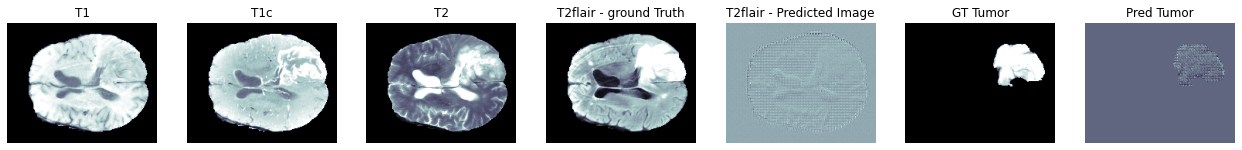

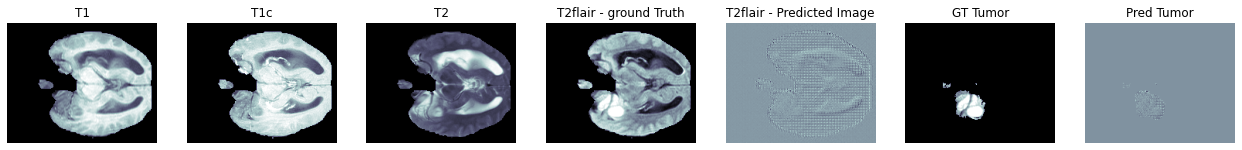

KeyboardInterrupt: ignored

In [68]:
EPOCHS = 15
save_checkpoint = True         # want to save new checkpoints ? 
save_final_models = False       # want to save the model at the end of the training ? 
epochs_already_trained = 0      # this is just for the print. 
evaluate_tumor_quality = True   # compute & print metrics on tumor area ?
print_loss = True               # compute & print the validation loss ?


# Initialize the models, so that I don't have to restart the runtime again.

if tf.equal(evaluate_tumor_quality, True) and tf.equal(print_loss, False):
    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = fit(training, EPOCHS, validation, save_checkpoint, 
                 
                                                    epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor)

elif tf.equal(evaluate_tumor_quality, False) and tf.equal(print_loss, True):
    psnr, mse, ssim, gen_loss, dis_loss = fit(training, EPOCHS, validation, save_checkpoint, 
                                                    epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim)
    plot_loss(gen_loss, dis_loss)

elif tf.equal(evaluate_tumor_quality, True) and tf.equal(print_loss, True):
    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, gen_loss, dis_loss = fit(training, EPOCHS, validation, save_checkpoint, 
                                                        epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor)
    plot_loss(gen_loss, dis_loss)
else:
    psnr, mse, ssim = fit(training, EPOCHS, validation, save_checkpoint, 
                                                      epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim)

# at the end, I'll save the models (I would need only the generator)
# (it saves the entire model to a HDF5 file)

if save_final_models:
    generator.save('drive/My Drive/MRI-generation/MI-GAN/gen_t1c_39ep.h5')

##Evaluating the final model with the test set

In [0]:
generator.save('drive/My Drive/MRI-generation/MI-GAN/gen_t1c_39ep.h5')

In [0]:
# Let's check the scores of this model.

evaluate_GAN(generator, testing, 'test', True, True)